In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
imsize = 512 if torch.cuda.is_available() else 512  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img_1 = image_loader("./style1.jpg")
style_img_2 = image_loader("./van.png")
content_img = image_loader("./corgi.jpg")

print(style_img_1.shape)
print(style_img_2.shape)
print(content_img.shape)

assert style_img_1.size() == content_img.size(), \
    "we need to import style and content images of the same size"

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


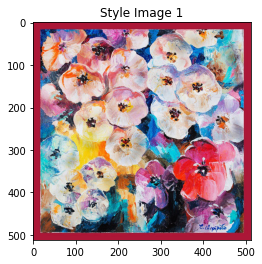

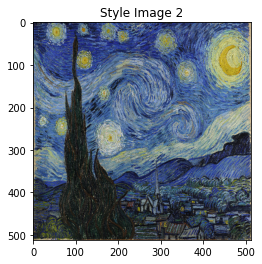

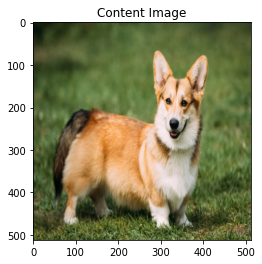

In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img_1, title='Style Image 1')

plt.figure()
imshow(style_img_2, title='Style Image 2')

plt.figure()
imshow(content_img, title='Content Image')

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature_1, target_feature_2):
        super(StyleLoss, self).__init__()
        self.target_1 = gram_matrix(target_feature_1).detach()
        self.target_2 = gram_matrix(target_feature_2).detach()

    def forward(self, input):
        G = gram_matrix(input)
        loss_1 = F.mse_loss(G, self.target_1)
        loss_2 = F.mse_loss(G, self.target_2)
        loss_sum = loss_1 + loss_2
        self.loss = 0.5 * loss_1 + 0.5 * loss_2
        return input

In [ ]:
class SmoothLoss(nn.Module):

  def __init__(self):
    super(SmoothLoss, self).__init__()

  def forward(self, input):
    REGULARIZATION = 0.001
    # a, b, h, w = input.size()

    # total_loss = 0
    # for c in range(b):
    #   for i in range(h - 1):
    #     for j in range(w - 1):
    #       total_loss += ((input[0][c][i][j+1] - input[0][c][i][j]) ** 2 + input[0][c][i+1][j] - input[0][c][i][j]) ** 2
    
    # self.loss = total_loss
    self.loss = REGULARIZATION * (
    torch.sum(torch.abs(input[:, :, :, :-1] - input[:, :, :, 1:])) + 
    torch.sum(torch.abs(input[:, :, :-1, :] - input[:, :, 1:, :])))

    # print('Other: ', self.loss)
    # print('My: ', total_loss)

    return input


In [ ]:
T_data = [[[1., 7.], [1000., 100.]],
          [[8., 6.], [7., 8.]]]

T = torch.tensor(T_data).unsqueeze(0)
loss = SmoothLoss()
loss(T)

tensor([[[[   1.,    7.],
          [1000.,  100.]],

         [[   8.,    6.],
          [   7.,    8.]]]])

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
smooth_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default, smooth_layers=smooth_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []
    smooth_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:

            target_feature_1 = model(style_img[0]).detach()
            target_feature_2 = model(style_img[1]).detach()
            style_loss = StyleLoss(target_feature_1, target_feature_2)

            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

        if name in smooth_layers:

            smooth_loss = SmoothLoss()
            model.add_module("smooth_loss_{}".format(i), smooth_loss)
            smooth_losses.append(smooth_loss)
          

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss) or isinstance(model[i], SmoothLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses, smooth_losses

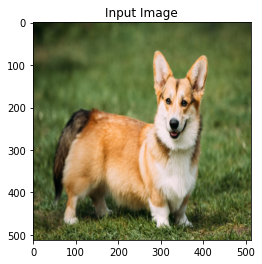

In [ ]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=50000, content_weight=1, smooth_weight=0.0001):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses, smooth_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0
            smooth_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
            for sl in smooth_losses:
                smooth_score += sl.loss
            

            style_score *= style_weight
            content_score *= content_weight
            smooth_score *= smooth_weight


            loss = style_score + content_score + smooth_score
            loss.backward()

            run[0] += 1
            if run[0] % 10 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f} Smooth Loss: {:4f}'.format(
                    style_score.item(), content_score.item(), smooth_score.item()))
                print()
                plt.figure()
                imshow(input_img, title='Output Image')

                # sphinx_gallery_thumbnail_number = 4
                plt.ioff()
                plt.show()

            return style_score + content_score + smooth_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [10]:
Style Loss : 422.236145 Content Loss: 29.005253 Smooth Loss: 21.892565



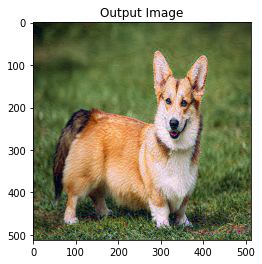

run [20]:
Style Loss : 331.706360 Content Loss: 31.789843 Smooth Loss: 23.094194



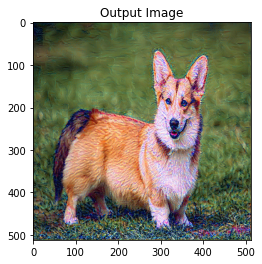

run [30]:
Style Loss : 302.637970 Content Loss: 32.353683 Smooth Loss: 22.784622



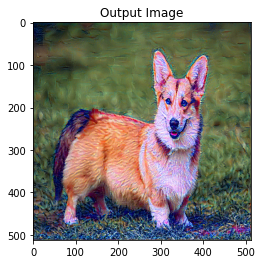

run [40]:
Style Loss : 293.592987 Content Loss: 31.584404 Smooth Loss: 22.674953



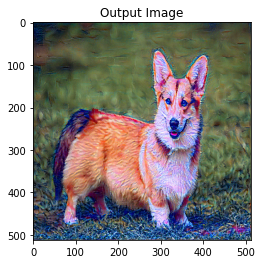

run [50]:
Style Loss : 287.800201 Content Loss: 31.135736 Smooth Loss: 22.396019



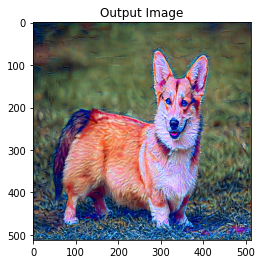

run [60]:
Style Loss : 285.681885 Content Loss: 30.085808 Smooth Loss: 21.983232



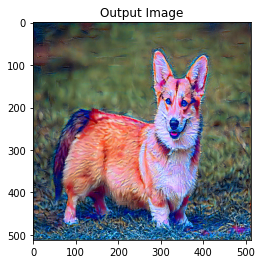

run [70]:
Style Loss : 283.922729 Content Loss: 29.259972 Smooth Loss: 21.487038



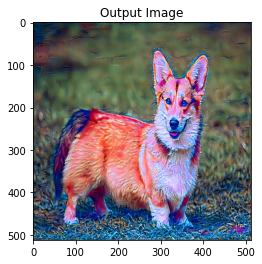

run [80]:
Style Loss : 283.141510 Content Loss: 28.479889 Smooth Loss: 21.021553



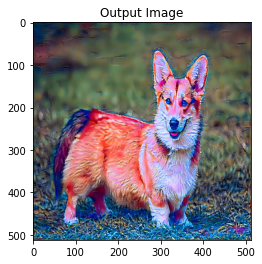

run [90]:
Style Loss : 282.840240 Content Loss: 27.949936 Smooth Loss: 20.678350



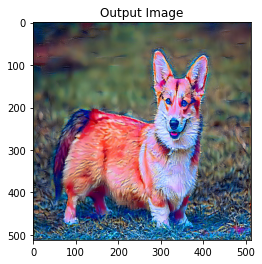

run [100]:
Style Loss : 282.433167 Content Loss: 27.659157 Smooth Loss: 20.433973



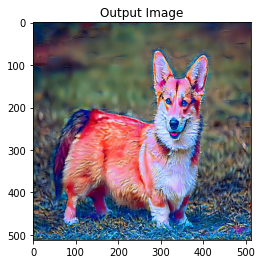

run [110]:
Style Loss : 282.229797 Content Loss: 27.313486 Smooth Loss: 20.089363



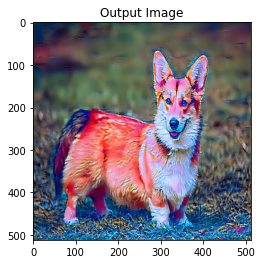

run [120]:
Style Loss : 282.097992 Content Loss: 27.035999 Smooth Loss: 19.851696



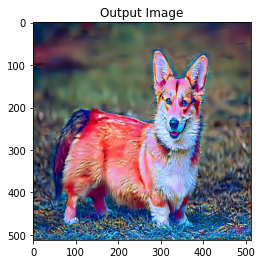

run [130]:
Style Loss : 281.892426 Content Loss: 26.863266 Smooth Loss: 19.587152



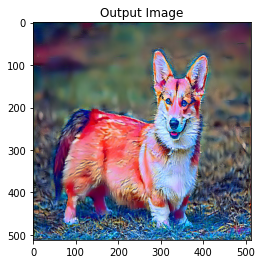

run [140]:
Style Loss : 281.897736 Content Loss: 26.649723 Smooth Loss: 19.455162



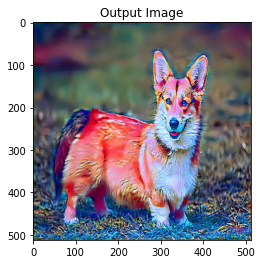

run [150]:
Style Loss : 281.806702 Content Loss: 26.558636 Smooth Loss: 19.180782



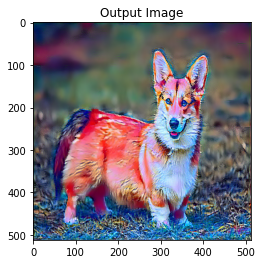

run [160]:
Style Loss : 281.860901 Content Loss: 26.538902 Smooth Loss: 19.274450



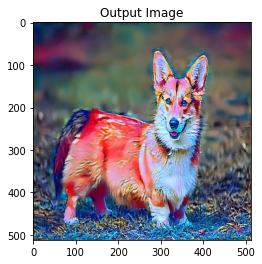

run [170]:
Style Loss : 281.799591 Content Loss: 26.351147 Smooth Loss: 19.037369



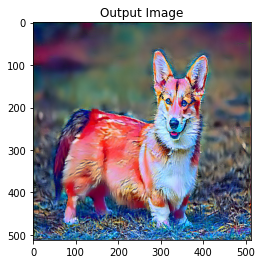

run [180]:
Style Loss : 282.872437 Content Loss: 25.937290 Smooth Loss: 18.724981



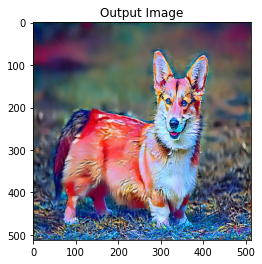

run [190]:
Style Loss : 281.777802 Content Loss: 26.286074 Smooth Loss: 18.910984



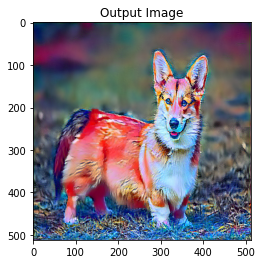

run [200]:
Style Loss : 281.801788 Content Loss: 26.171417 Smooth Loss: 18.629671



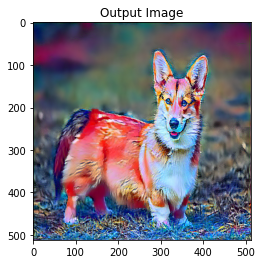

run [210]:
Style Loss : 281.762085 Content Loss: 26.261616 Smooth Loss: 18.691118



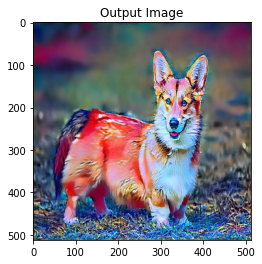

run [220]:
Style Loss : 282.056213 Content Loss: 26.500256 Smooth Loss: 19.354736



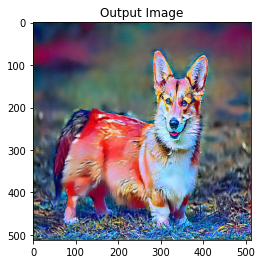

run [230]:
Style Loss : 282.995361 Content Loss: 26.843674 Smooth Loss: 19.624897



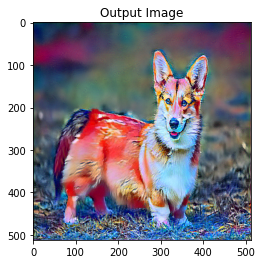

run [240]:
Style Loss : 282.177979 Content Loss: 26.104744 Smooth Loss: 18.674582



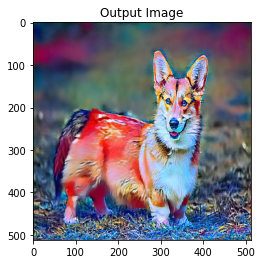

run [250]:
Style Loss : 281.738617 Content Loss: 26.262678 Smooth Loss: 18.716747



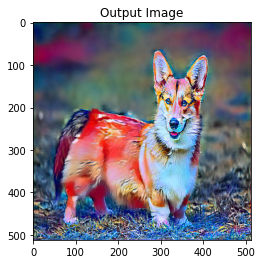

run [260]:
Style Loss : 281.792511 Content Loss: 26.280792 Smooth Loss: 18.686041



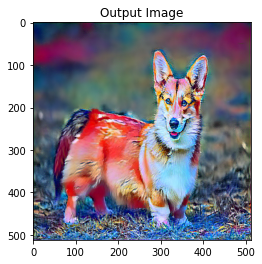

run [270]:
Style Loss : 284.566254 Content Loss: 25.675869 Smooth Loss: 18.545008



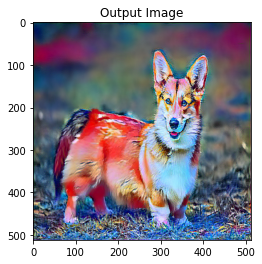

run [280]:
Style Loss : 281.901703 Content Loss: 26.378260 Smooth Loss: 18.923899



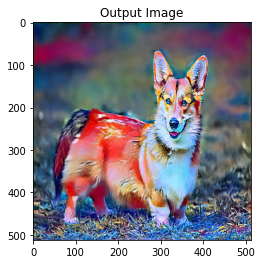

run [290]:
Style Loss : 293.988190 Content Loss: 25.907753 Smooth Loss: 19.902931



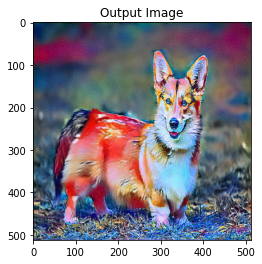

run [300]:
Style Loss : 281.941498 Content Loss: 26.740280 Smooth Loss: 19.258272



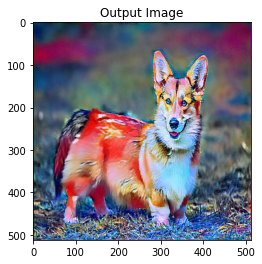

run [310]:
Style Loss : 282.102905 Content Loss: 26.388340 Smooth Loss: 18.892694



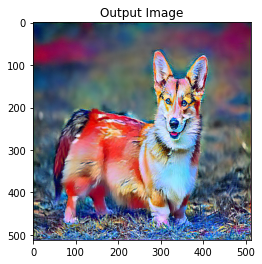

run [320]:
Style Loss : 281.873779 Content Loss: 26.262215 Smooth Loss: 18.777605



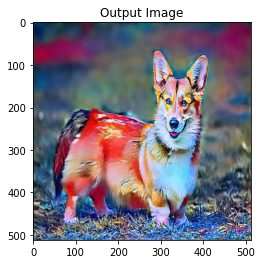

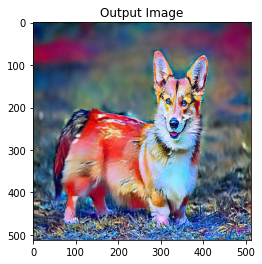

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, [style_img_1, style_img_2], input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()